# Image partitioning logic


ref: https://scikit-image.org/docs/stable/user_guide/numpy_images.html

In [26]:
import numpy as np
import scipy as sp
import skimage as ski

import matplotlib.pyplot as plt
import io
from PIL import Image
from matplotlib.patches import Rectangle

In [27]:
image_path = './airport.png'
image = ski.io.imread(image_path)
image_np = np.array(image)


# Old logic

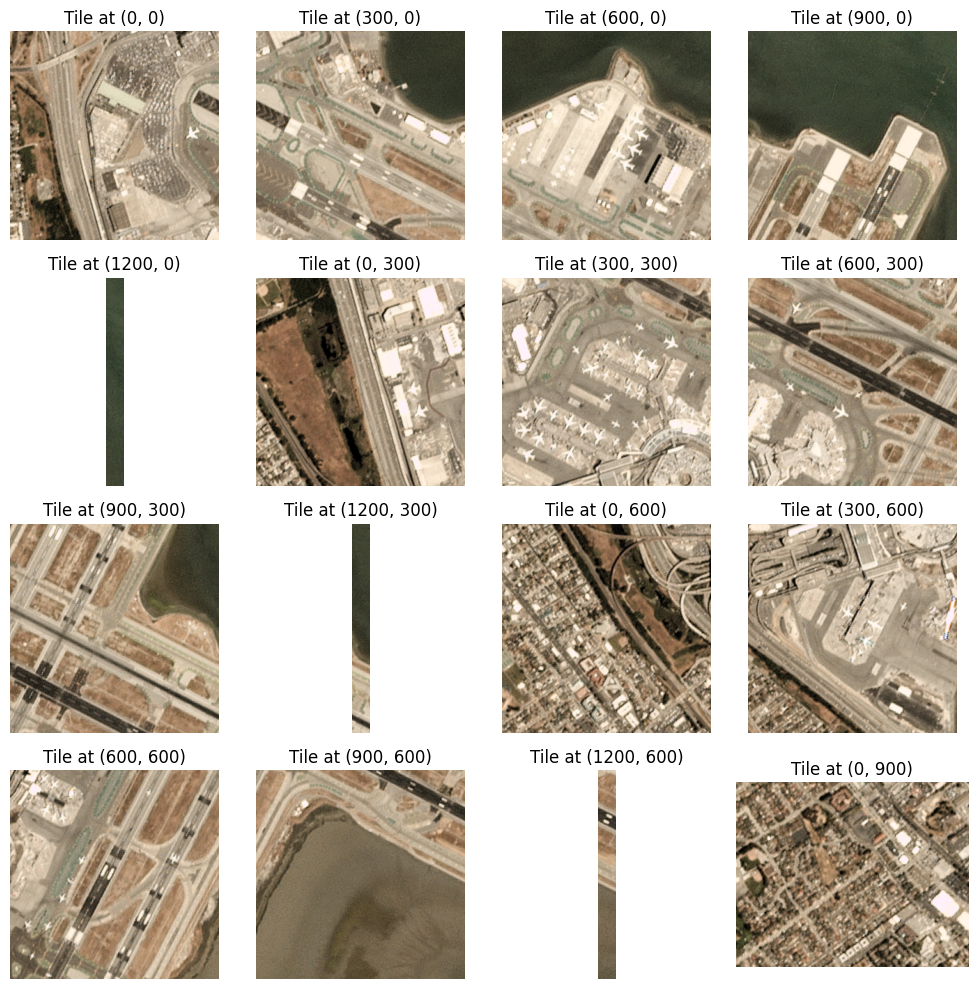

In [28]:
# Image partitioning parameters
tile_size = 300
img_height, img_width = image_np.shape[:2]  # Using numpy array shape
tiles = []  # List to store all tiles

# Partition the image into tiles
for y_offset in range(0, img_height, tile_size):
    for x_offset in range(0, img_width, tile_size):
        # Ensure we don't go beyond the image boundary
        x_end = min(x_offset + tile_size, img_width)
        y_end = min(y_offset + tile_size, img_height)
        
        # Extract tile from numpy array
        tile = image_np[y_offset:y_end, x_offset:x_end]
        tiles.append({
            'tile': tile,
            'x_offset': x_offset,
            'y_offset': y_offset,
            'width': x_end - x_offset,
            'height': y_end - y_offset
        })

# Optional: Visualize a few tiles
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    if idx < min(16, len(tiles)):
        ax.imshow(tiles[idx]['tile'])
        ax.set_title(f"Tile at ({tiles[idx]['x_offset']}, {tiles[idx]['y_offset']})")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Proposed new logic

In [29]:

OBJECTSIZE = 32 #m - Size of the object in meters (max dimension)
RESOLUTION = 2 #pixels per meter (resolution of satalite image)
OBJECTSINFRAME = 4 #number of objects that fit in the frame

PIXELSIZE = OBJECTSIZE * RESOLUTION #pixels the object takes up in image
FRAMEPIXELSIZE = PIXELSIZE * OBJECTSINFRAME #pixels per meter


In [30]:
# image_np.shape

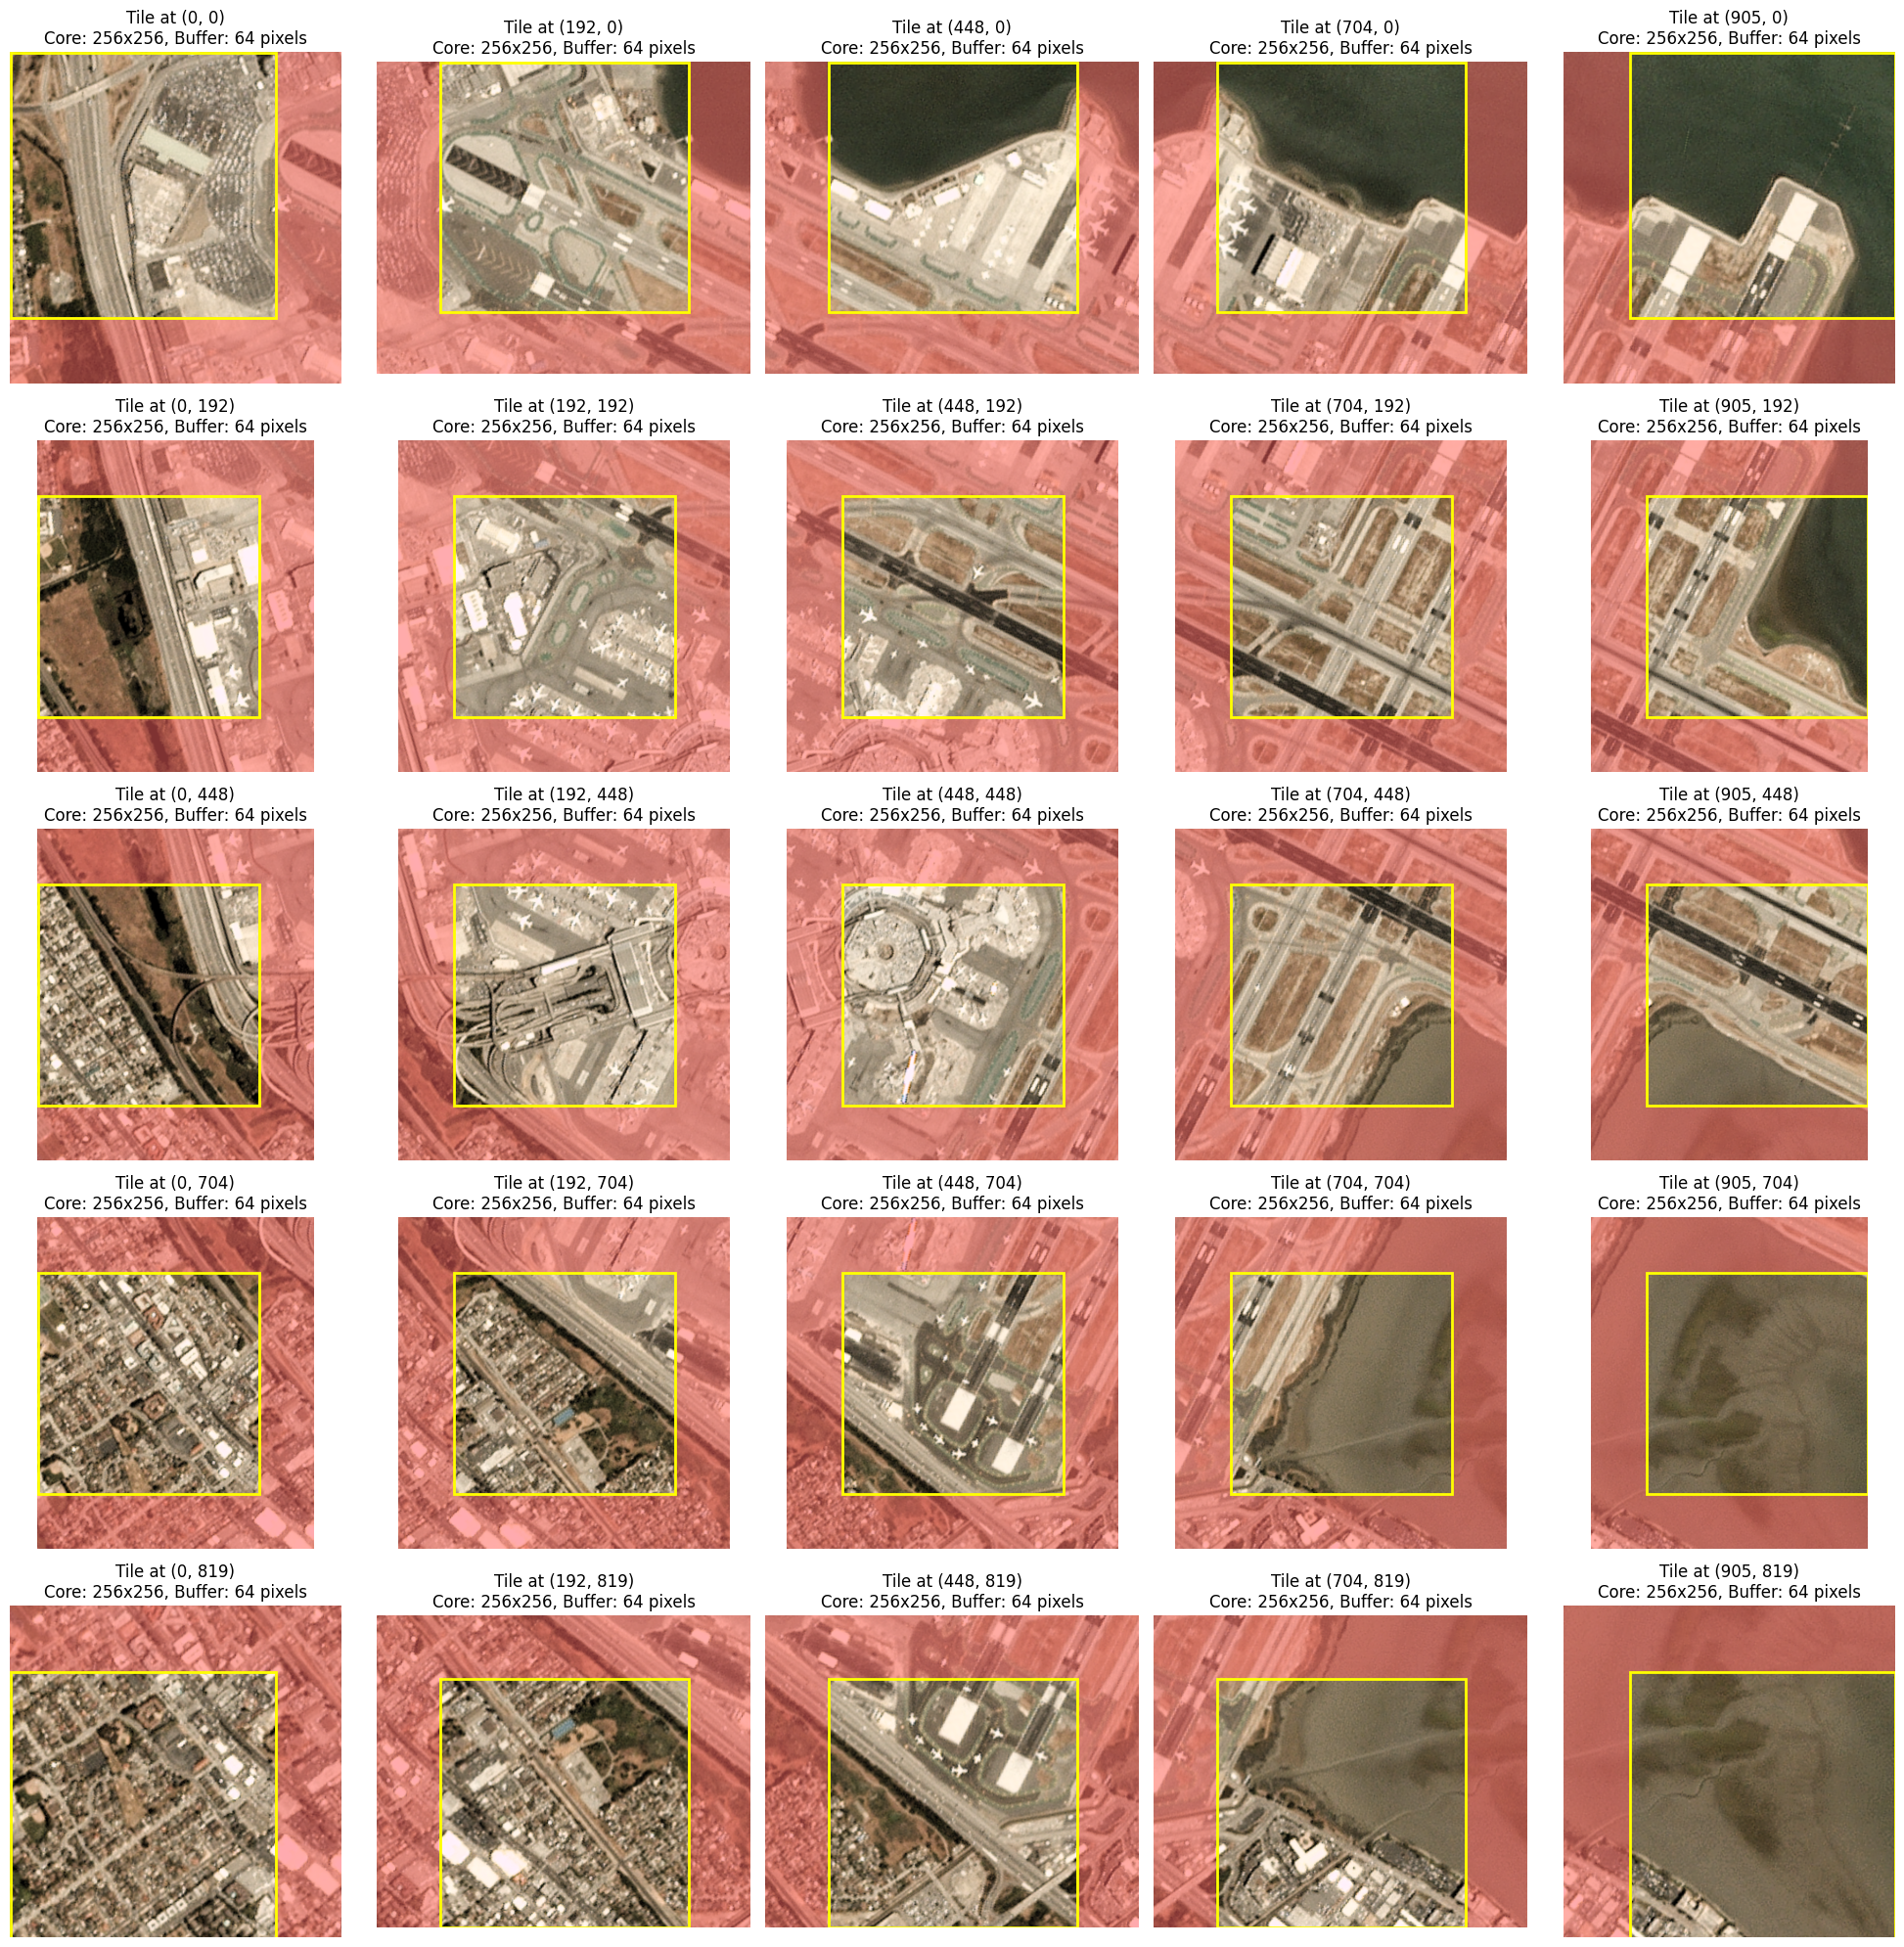

Displaying all 25 tiles in a 5x5 grid


In [31]:
# Image partitioning with buffer
tiles = []
img_height, img_width = image_np.shape[:2] #width and height

# Calculate steps to ensure full coverage with overlap at the edges
def get_positions(total_size, frame_size):
    positions = list(range(0, total_size - frame_size + 1, frame_size))
    if total_size - positions[-1] > 0:  # if there's remaining space
        positions.append(total_size - frame_size)  # overlap with previous grid
    return positions

x_positions = get_positions(img_width, FRAMEPIXELSIZE)
y_positions = get_positions(img_height, FRAMEPIXELSIZE)

for y_offset in y_positions:
    for x_offset in x_positions:
        # Core frame coordinates
        x_end = x_offset + FRAMEPIXELSIZE
        y_end = y_offset + FRAMEPIXELSIZE
        
        # Buffer zone coordinates
        x_buff_start = max(0, x_offset - PIXELSIZE)
        y_buff_start = max(0, y_offset - PIXELSIZE)
        x_buff_end = min(img_width, x_end + PIXELSIZE)
        y_buff_end = min(img_height, y_end + PIXELSIZE)
        
        full_tile = image_np[y_buff_start:y_buff_end, x_buff_start:x_buff_end].copy()
        
        # relative positions for core area in the buffered tile
        core_start_y = y_offset - y_buff_start
        core_start_x = x_offset - x_buff_start
        core_end_y = core_start_y + FRAMEPIXELSIZE
        core_end_x = core_start_x + FRAMEPIXELSIZE
        
        # overlay for buffer zone
        overlay = np.ones_like(full_tile) * [255, 100, 100]  # Light red tint RGB
        mask = np.ones_like(full_tile, dtype=bool)
        mask[core_start_y:core_end_y, core_start_x:core_end_x] = False
        full_tile[mask] = full_tile[mask] * 0.5 + overlay[mask] * 0.5 #color weights
        
        tiles.append({
            'tile': full_tile,
            'x_offset': x_buff_start,
            'y_offset': y_buff_start,
            'core_start': (core_start_x, core_start_y),
            'core_size': FRAMEPIXELSIZE,
            'width': x_buff_end - x_buff_start,
            'height': y_buff_end - y_buff_start
        })

# Visualization
n_tiles = len(tiles)
n_cols = int(np.ceil(np.sqrt(n_tiles)))  # square-ish layout
n_rows = int(np.ceil(n_tiles / n_cols))

# Visualization
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20 * n_rows/n_cols))
axes = axes.flat if n_rows > 1 or n_cols > 1 else [axes]  # Handle single-plot case

for idx, ax in enumerate(axes):
    if idx < n_tiles:
        tile_data = tiles[idx]
        ax.imshow(tile_data['tile'])
        
        # Draw rectangle around core area
        rect = Rectangle(
            tile_data['core_start'],
            tile_data['core_size'],
            tile_data['core_size'],
            fill=False,
            color='yellow',
            linewidth=2
        )
        ax.add_patch(rect)
        
        ax.set_title(f"Tile at ({tile_data['x_offset']}, {tile_data['y_offset']})\n"
                    f"Core: {FRAMEPIXELSIZE}x{FRAMEPIXELSIZE}, Buffer: {PIXELSIZE} pixels")
    else:
        ax.remove()  # Remove empty subplots
    
    if idx < n_tiles:
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Displaying all {n_tiles} tiles in a {n_rows}x{n_cols} grid")